In [22]:
import os
import random
import json
import numpy as np
import cv2
import albumentations as A
import tensorflow as tf
from classification_models.tfkeras import Classifiers
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
seed = 42
backbone = "seresnet34"
dataset = "/mnt/HDD/Backup/Thesis/Maksim/whaleshark/data/dataset_id_filtered"
epochs = 50
batch_size = 14
shape = 512

In [4]:
random.seed(seed)

In [5]:
images = []
labels = []
walks = list(os.walk(dataset))[1:]

for path, dirs, files in walks:
    annotations = []

    for file in files:
        if os.path.splitext(file)[1] == ".json":
            with open(path + os.sep + file) as json_file:
                data = json.load(json_file)
                
                for entry in data:
                    annotations.append(entry[0])
    
    for file in files:
        if os.path.splitext(file)[1] != ".json":
            images.append(path + os.sep + file)
            
            if file in annotations:
                labels.append(1)
            else:
                labels.append(0)

images = np.array(images)
labels = np.array(labels)

In [6]:
transform_train = A.Compose([
    A.OneOf([
        A.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, rotate=(-15, 15), shear=(-10, 10), p=0.5),
        A.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, shear=(-10, 10), p=0.5),
    ], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Resize(height=shape, width=shape, p=1.0)
])
transform_test = A.Compose([
    A.Resize(height=shape, width=shape, p=1.0)
])

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, transform, batch_size, shape, shuffle=True):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.indexes = None
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        temp_images = [self.images[i] for i in indexes]
        x = self.__data_generation(temp_images)
        y = np.array([self.labels[i] for i in indexes], dtype=np.float32)

        return x, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, temp_images):
        x = np.zeros(shape=(len(temp_images), self.shape, self.shape, 3), dtype=np.float32)

        for i, image_path in enumerate(temp_images):
            image = cv2.imread(image_path)
            transformed = self.transform(image=image)
            x[i] = transformed["image"].astype(np.float32) / 255

        return x

In [8]:
def augmentations_example(folds_model, images, labels, sample_size=8):
    for fold_id, (train_index, test_index) in enumerate(folds_model.split(images, labels)):
        train_images, test_images = images[train_index], images[test_index]
        train_labels, test_labels = labels[train_index], labels[test_index]
        train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                                test_size=0.1, random_state=seed)
        data_generator = DataGenerator(images=train_images, labels=train_labels, transform=transform_train,
                                       batch_size=sample_size, shape=shape)
        images, labels = data_generator[0]
        fig, axarr = plt.subplots(sample_size // 2, 2, figsize=(10, 10))

        for i in range(sample_size // 2):
            axarr[i][0].axis("off")
            axarr[i][1].axis("off")
            axarr[i][0].imshow((images[i][:, :, ::-1] * 255).astype(np.uint8))
            axarr[i][1].imshow((images[sample_size // 2 + i][:, :, ::-1] * 255).astype(np.uint8))

        plt.savefig("augmentations.png")
        break

In [9]:
def save_plots(history, fold_id):
    plt.clf()
    plt.plot(history.history["accuracy"], "b-")
    plt.plot(history.history["val_accuracy"], "g-")
    plt.title("Metrics")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend(["train", "val"])
    plt.savefig("logs/fold_{0}_accuracy.png".format(fold_id))
    plt.clf()
    plt.plot(history.history["loss"], "b-")
    plt.plot(history.history["val_loss"], "g-")
    plt.title("Metrics")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend(["train", "val"])
    plt.savefig("logs/fold_{0}_loss.png".format(fold_id))

In [20]:
def tta(image, model):
    flipped = np.fliplr(image)
    predicted = model.predict(np.expand_dims(image, axis=0))[0][0]
    predicted_flipped = model.predict(np.expand_dims(flipped, axis=0))[0][0]

    return (predicted + predicted_flipped) / 2

In [10]:
 # Create folds model.
folds_model = KFold(n_splits=4)

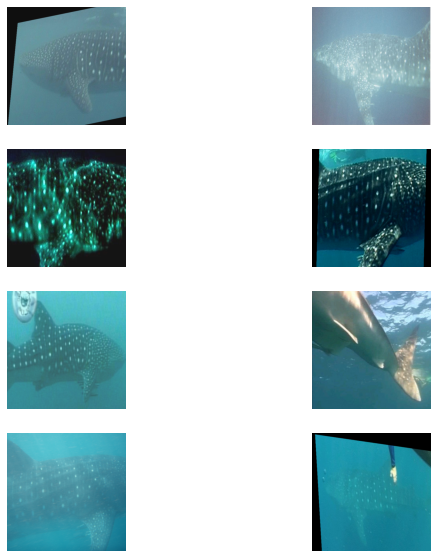

In [11]:
augmentations_example(folds_model, images, labels)

Epoch 1/50
325/325 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.6485
Epoch 00001: val_accuracy improved from -inf to 0.48617, saving model to models/fold_0/epoch_01.h5
325/325 [==============================] - 204s 608ms/step - loss: 0.7152 - accuracy: 0.6486 - val_loss: 1.0286 - val_accuracy: 0.4862
Epoch 2/50
325/325 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.6861
Epoch 00002: val_accuracy did not improve from 0.48617
325/325 [==============================] - 194s 596ms/step - loss: 0.5980 - accuracy: 0.6861 - val_loss: 0.8835 - val_accuracy: 0.4862
Epoch 3/50
325/325 [==============================] - ETA: 0s - loss: 0.5422 - accuracy: 0.7378
Epoch 00003: val_accuracy improved from 0.48617 to 0.75494, saving model to models/fold_0/epoch_03.h5
325/325 [==============================] - 194s 595ms/step - loss: 0.5421 - accuracy: 0.7378 - val_loss: 0.5298 - val_accuracy: 0.7549
Epoch 4/50
325/325 [==============================]

325/325 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8546
Epoch 00026: val_accuracy did not improve from 0.83992

Epoch 00026: ReduceLROnPlateau reducing learning rate to 6.553600542247295e-07.
325/325 [==============================] - 186s 572ms/step - loss: 0.3308 - accuracy: 0.8546 - val_loss: 0.3480 - val_accuracy: 0.8241
Epoch 27/50
325/325 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.8486
Epoch 00027: val_accuracy did not improve from 0.83992
325/325 [==============================] - 185s 568ms/step - loss: 0.3252 - accuracy: 0.8486 - val_loss: 0.3487 - val_accuracy: 0.8261
Epoch 28/50
325/325 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.8593
Epoch 00028: val_accuracy did not improve from 0.83992

Epoch 00028: ReduceLROnPlateau reducing learning rate to 2.6214402168989184e-07.
325/325 [==============================] - 184s 567ms/step - loss: 0.3225 - accuracy: 0.8593 - val_loss: 0.3498 - val_accur

Epoch 2/50
325/325 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.7640
Epoch 00002: val_accuracy improved from 0.45257 to 0.59881, saving model to models/fold_1/epoch_02.h5
325/325 [==============================] - 185s 569ms/step - loss: 0.4825 - accuracy: 0.7640 - val_loss: 0.8596 - val_accuracy: 0.5988
Epoch 3/50
325/325 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.7775
Epoch 00003: val_accuracy improved from 0.59881 to 0.80435, saving model to models/fold_1/epoch_03.h5
325/325 [==============================] - 184s 566ms/step - loss: 0.4825 - accuracy: 0.7775 - val_loss: 0.4477 - val_accuracy: 0.8043
Epoch 4/50
325/325 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.7903
Epoch 00004: val_accuracy did not improve from 0.80435
325/325 [==============================] - 185s 568ms/step - loss: 0.4568 - accuracy: 0.7903 - val_loss: 0.5313 - val_accuracy: 0.7925
Epoch 5/50
325/325 [============================

325/325 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.8789
Epoch 00027: val_accuracy did not improve from 0.87945
325/325 [==============================] - 183s 563ms/step - loss: 0.2743 - accuracy: 0.8789 - val_loss: 0.3377 - val_accuracy: 0.8617
Epoch 28/50
325/325 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.8762
Epoch 00028: val_accuracy did not improve from 0.87945

Epoch 00028: ReduceLROnPlateau reducing learning rate to 4.1943044948311586e-08.
325/325 [==============================] - 184s 565ms/step - loss: 0.2743 - accuracy: 0.8762 - val_loss: 0.3409 - val_accuracy: 0.8617
Epoch 29/50
325/325 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.8846
Epoch 00029: val_accuracy did not improve from 0.87945
325/325 [==============================] - 184s 566ms/step - loss: 0.2688 - accuracy: 0.8846 - val_loss: 0.3380 - val_accuracy: 0.8636
Epoch 30/50
325/325 [==============================] - ETA: 0s - loss

325/325 [==============================] - 183s 563ms/step - loss: 0.4488 - accuracy: 0.7782 - val_loss: 0.6651 - val_accuracy: 0.7115
Epoch 4/50
325/325 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.7976
Epoch 00004: val_accuracy improved from 0.71146 to 0.80830, saving model to models/fold_2/epoch_04.h5
325/325 [==============================] - 185s 569ms/step - loss: 0.4449 - accuracy: 0.7976 - val_loss: 0.4456 - val_accuracy: 0.8083
Epoch 5/50
325/325 [==============================] - ETA: 0s - loss: 0.4317 - accuracy: 0.8064
Epoch 00005: val_accuracy improved from 0.80830 to 0.82806, saving model to models/fold_2/epoch_05.h5
325/325 [==============================] - 184s 565ms/step - loss: 0.4317 - accuracy: 0.8064 - val_loss: 0.3914 - val_accuracy: 0.8281
Epoch 6/50
325/325 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8162
Epoch 00006: val_accuracy did not improve from 0.82806
325/325 [==============================] - 183s 

Epoch 29/50
325/325 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.8900
Epoch 00029: val_accuracy did not improve from 0.85375

Epoch 00029: ReduceLROnPlateau reducing learning rate to 4.1943044948311586e-08.
325/325 [==============================] - 185s 569ms/step - loss: 0.2530 - accuracy: 0.8900 - val_loss: 0.3808 - val_accuracy: 0.8399
Epoch 30/50
325/325 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.8941
Epoch 00030: val_accuracy did not improve from 0.85375
325/325 [==============================] - 183s 562ms/step - loss: 0.2466 - accuracy: 0.8940 - val_loss: 0.3802 - val_accuracy: 0.8399
Epoch 31/50
325/325 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.8962
Epoch 00031: val_accuracy did not improve from 0.85375

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.677721854775882e-08.
325/325 [==============================] - 184s 567ms/step - loss: 0.2523 - accuracy: 0.8961 - val_loss: 0.3836

325/325 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.7819
Epoch 00005: val_accuracy did not improve from 0.77470
325/325 [==============================] - 184s 565ms/step - loss: 0.4475 - accuracy: 0.7820 - val_loss: 0.9397 - val_accuracy: 0.6996
Epoch 6/50
325/325 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.7925
Epoch 00006: val_accuracy did not improve from 0.77470

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
325/325 [==============================] - 184s 567ms/step - loss: 0.4269 - accuracy: 0.7924 - val_loss: 0.5406 - val_accuracy: 0.7747
Epoch 7/50
325/325 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.8037
Epoch 00007: val_accuracy improved from 0.77470 to 0.81621, saving model to models/fold_3/epoch_07.h5
325/325 [==============================] - 185s 569ms/step - loss: 0.4178 - accuracy: 0.8037 - val_loss: 0.3953 - val_accuracy: 0.8162
Epoch 8/50
325/325 [=====

325/325 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9180
Epoch 00030: val_accuracy did not improve from 0.84783
325/325 [==============================] - 185s 570ms/step - loss: 0.2038 - accuracy: 0.9180 - val_loss: 0.4895 - val_accuracy: 0.8399
Epoch 31/50
325/325 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9125
Epoch 00031: val_accuracy did not improve from 0.84783

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0485761094969349e-07.
325/325 [==============================] - 185s 570ms/step - loss: 0.2077 - accuracy: 0.9125 - val_loss: 0.4893 - val_accuracy: 0.8399
Epoch 32/50
325/325 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9111
Epoch 00032: val_accuracy did not improve from 0.84783
325/325 [==============================] - 186s 572ms/step - loss: 0.2007 - accuracy: 0.9111 - val_loss: 0.4919 - val_accuracy: 0.8379
Epoch 33/50
325/325 [==============================] - ETA: 0s - loss

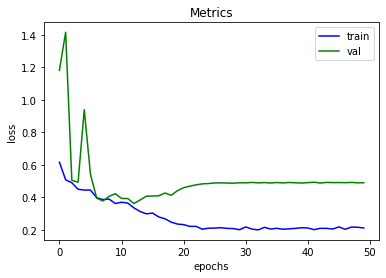

In [12]:
# Train 4 models on each fold.
for fold_id, (train_index, test_index) in enumerate(folds_model.split(images, labels)):
    fold = "models/fold_{0}".format(fold_id)

    if not os.path.exists(fold):
        os.makedirs(fold)

    train_images, test_images = images[train_index], images[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                          test_size=0.1, random_state=seed)

    ModelBuilder, _ = Classifiers.get(backbone)
    base_model = ModelBuilder(input_shape=(shape, shape, 3), weights="imagenet", include_top=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(fold + "/epoch_{epoch:02d}.h5", monitor="val_accuracy", mode="max",
                                           save_weights_only=True, save_best_only=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.4, patience=2, verbose=1,
                                             mode="max", min_lr=0.000000001),
    ]
    train_generator = DataGenerator(images=train_images, labels=train_labels, transform=transform_train,
                                    batch_size=batch_size, shape=shape)
    val_generator = DataGenerator(images=val_images, labels=val_labels, transform=transform_test,
                                  batch_size=batch_size, shape=shape, shuffle=False)
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=callbacks)
    save_plots(history, fold_id)
    model.load_weights("{0}/".format(fold) + sorted(os.listdir(fold))[-1])
    model.save_weights("{0}/best.h5".format(fold))

In [47]:
mean_accuracy = []

for fold_id, (train_index, test_index) in enumerate(folds_model.split(images, labels)):
    fold = "models/fold_{0}".format(fold_id)
    test_images, test_labels = images[test_index], labels[test_index]
    ModelBuilder, _ = Classifiers.get(backbone)
    base_model = ModelBuilder(input_shape=(shape, shape, 3), weights="imagenet", include_top=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])
    model.load_weights("{0}/best.h5".format(fold))
    results = []

    for i, (image_path, label) in tqdm(enumerate(zip(test_images, test_labels)), total=len(test_images)):
        original = cv2.imread(image_path)
        transformed = transform_test(image=original)
        image = transformed["image"].astype(np.float32) / 255
        predicted = tta(image, model)
        captioned = original.copy()

        if predicted >= 0.5:
            cv2.putText(captioned, "GOOD: {0:.2f}".format(predicted), (40, 70), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 255, 0), 1)
        else:
            cv2.putText(captioned, "BAD: {0:.2f}".format(predicted), (40, 70), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 0, 255), 1)

        captioned_path = "/".join(image_path.split("/")[:-3]) + os.sep + "view_predicted"

        if not os.path.exists(captioned_path):
            os.makedirs(captioned_path)

        cv2.imwrite(captioned_path  + os.sep + image_path.split("/")[-1], captioned)
        results.append(predicted)

    results = np.array(results)
    results[results >= 0.5] = 1
    results[results < 0.5] = 0
    accuracy = accuracy_score(test_labels, results)
    mean_accuracy.append(accuracy)
    print("Fold {0} Accuracy: {1:.3f}".format(fold_id, accuracy))

print("Accuracy: {0:.3f}".format(np.mean(mean_accuracy)))

100%|██████████| 1685/1685 [04:12<00:00,  6.68it/s]


Fold 0 Accuracy: 0.846


100%|██████████| 1685/1685 [04:11<00:00,  6.69it/s]


Fold 1 Accuracy: 0.807


100%|██████████| 1684/1684 [04:12<00:00,  6.67it/s]


Fold 2 Accuracy: 0.806


100%|██████████| 1684/1684 [04:07<00:00,  6.80it/s]

Fold 3 Accuracy: 0.824
Accuracy: 0.821
